In [39]:
# path =r'C:\Users\bartama\Desktop\PoliMi Stuff\NLP Stuff\Project'
# path = path+"\\tiny.jsonl"
# import pickle
# import gzip
# data_list = []

# # Read the JSONL file
# with open(path, 'r') as file:
#     for line in file:
#         json_obj = json.loads(line)
#         data_list.append(json_obj)
# output_path = "data_list.pkl.gz"
# with gzip.open(output_path, 'wb') as f:
#     pickle.dump(data_list, f)

## Libraries

In [1]:
import pandas as pd
import pickle
import gzip
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.tokenize import  word_tokenize

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer, pipeline
from huggingface_hub import hf_hub_download

C:\Users\bartama\AppData\Local\Temp\ipykernel_15268\2221607056.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Helper Functions


In [ ]:
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

def remove_stopwords_and_digits(tokens):
    return [token for token in tokens if token.lower() not in stop_words and not token.isdigit()]

## Reading things in

For you guys

In [2]:
from datasets import load_dataset
data_list = load_dataset("Open-Orca/SlimOrca")

In [3]:
#This is for Marci
input_path = "data_list.pkl.gz"

with gzip.open(input_path, 'rb') as f:
    data_list = pickle.load(f)


##  Wrangling

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
# Extract 'conversations' fields
conversations_list = [item.get('conversations', []) for item in data_list]

# Check if there are any non-conversation items
non_conversation_items = [item for item in conversations_list if not isinstance(item, list)]
print(f"We have {len(non_conversation_items)} non_conversation_items in our dataset" )

We have 0 non_conversation_items in our dataset


In [7]:
conversations_dict = {idx: conv for idx, conv in enumerate(conversations_list)}

In [8]:
flattened_data = []
for conv_id, conv in enumerate(conversations_list):
    for msg in conv:
        flattened_data.append({'conv_id': conv_id,
                               'msg': msg['value'],
                               'from': msg['from'],
                               'weight': msg.get('weight'),
                               'message_length': len(msg['value'].split())})
df = pd.DataFrame(flattened_data)

In [10]:
# Calculate summary statistics
messages_per_conversation = df.groupby('conv_id').size().rename('message_count_not_clean')
average_message_length = df.groupby('conv_id')['message_length_not_clean'].mean().rename('average_message_length_not_clean_with:system_human_gpt')

# Merge these statistics back into the original DataFrame
df = df.join(messages_per_conversation, on='conv_id')
df = df.join(average_message_length, on='conv_id')

# Tokenize the messages and count unique words per conversation
df['tokens_not_clean'] = df['msg'].str.lower().str.split()  # Tokenize and convert to lowercase

In [12]:
# further cleaning
df['tokens_cleaned_stopwords'] = df['tokens_not_clean'].apply(remove_stopwords)
df['tokens_cleaned_stopwords_digits'] = df['tokens_not_clean'].apply(remove_stopwords_and_digits)


In [16]:
# getting length of cleaned texts
df['message_length_stopwords'] = df['tokens_cleaned_stopwords'].apply(lambda tokens: len(tokens))
df['message_length_stopwords_digits'] = df['tokens_cleaned_stopwords_digits'].apply(lambda tokens: len(tokens))

In [27]:
# getting vocab of texts
df['vocab_length_byid_not_clean']            = df.groupby('conv_id')['tokens_not_clean'].transform(lambda tokens: len(set(sum(tokens.tolist(), []))))
df['vocab_length_byid_no_stopwords']         = df.groupby('conv_id')['tokens_cleaned_stopwords'].transform(lambda tokens: len(set(sum(tokens.tolist(), []))))
df['vocab_length_byid_no_stopwords_digits']  = df.groupby('conv_id')['tokens_cleaned_stopwords_digits'].transform(lambda tokens: len(set(sum(tokens.tolist(), []))))


In [76]:
df.head() ############# as you can see we have tokens like: 1:, "a

,conv_id,msg,from,weight,message_length,message_count,average_message_length_with:system_human_gpt,tokens_not_clean,tokens_cleaned_stopwords,tokens_cleaned_stopwords_digits,message_length_stopwords_digits,message_length_stopwords,vocab_length_byid_stopwords_digits,vocab_length_byid_not_clean,vocab_length_byid_no_stopwords,vocab_length_byid_no_stopwords_digits
0,0,You are an AI assistant. You will be given a t...,system,NaN,19,3,214.333333,"[you, are, an, ai, assistant., you, will, be, ...","[ai, assistant., given, task., must, generate,...","[ai, assistant., given, task., must, generate,...",9,9,276.0,327,276,276
1,0,"Write an article based on this ""A man has been...",human,0.0,36,3,214.333333,"[write, an, article, based, on, this, ""a, man,...","[write, article, based, ""a, man, charged, murd...","[write, article, based, ""a, man, charged, murd...",16,16,63.0,327,276,276
2,0,Title: Tragedy Strikes in Sydney: Victims Stab...,gpt,1.0,588,3,214.333333,"[title:, tragedy, strikes, in, sydney:, victim...","[title:, tragedy, strikes, sydney:, victims, s...","[title:, tragedy, strikes, sydney:, victims, s...",328,328,60.0,327,276,276
3,1,You are an AI assistant that follows instructi...,system,NaN,16,3,43.333333,"[you, are, an, ai, assistant, that, follows, i...","[ai, assistant, follows, instruction, extremel...","[ai, assistant, follows, instruction, extremel...",9,9,126.0,87,75,63
4,1,Answer the following question: - number is 54 ...,human,0.0,101,3,43.333333,"[answer, the, following, question:, -, number,...","[answer, following, question:, -, number, 54, ...","[answer, following, question:, -, number, -, d...",65,78,106.0,87,75,63


## Overview and Plotting

In [30]:
mystring = f"We have {len(df.conv_id.unique())} conversations in our dataset"
print(mystring)

We have 517982 conversations in our dataset


**We will porbably have to filter it down to just inputs:**

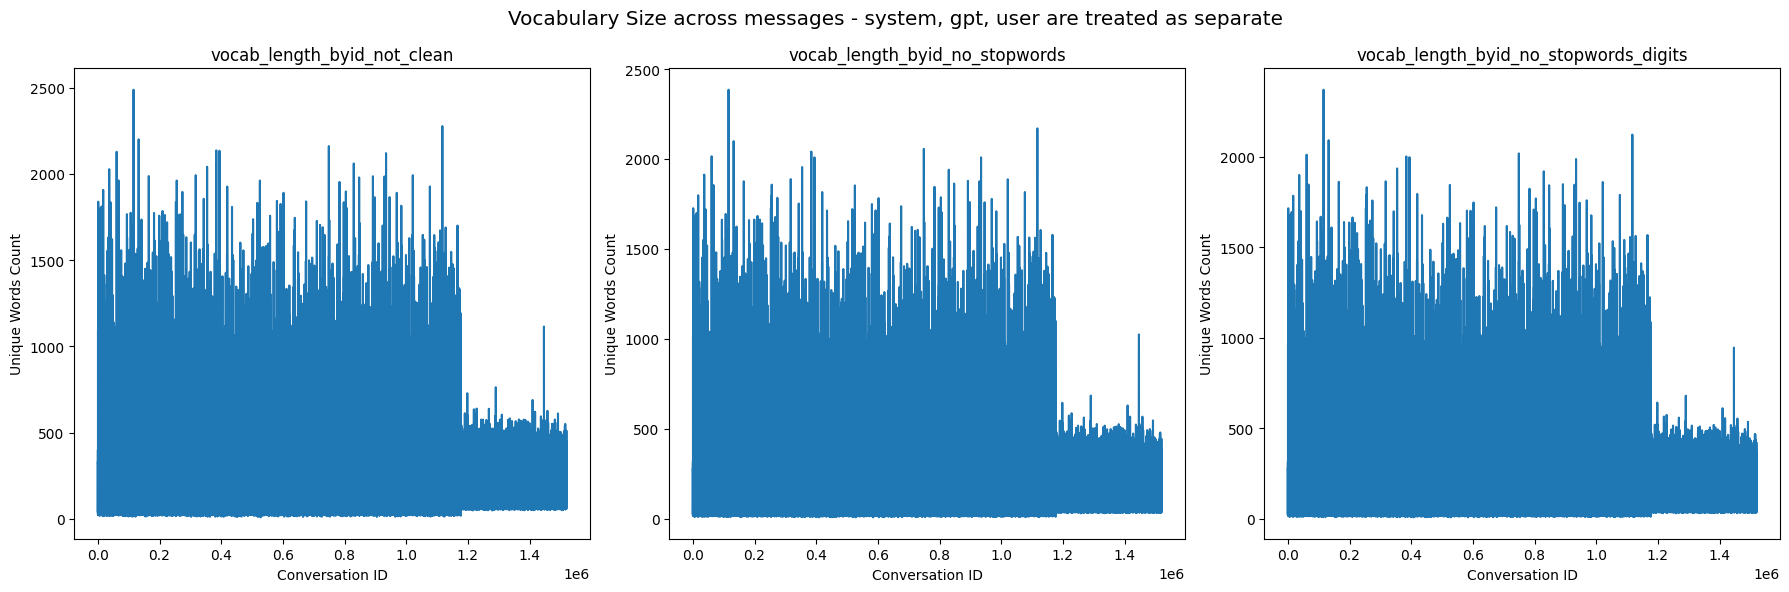

In [74]:
# Plot the vocabulary size per conversation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i in range(3):
    temp = df[['vocab_length_byid_not_clean', 'vocab_length_byid_no_stopwords', 'vocab_length_byid_no_stopwords_digits']].iloc[:, i]    
    axes[i].plot(temp.values)
    axes[i].set_title(temp.name)  # Set subplot title to temp.name
    axes[i].set_xlabel('Conversation ID')
    axes[i].set_ylabel('Unique Words Count')

plt.suptitle('Vocabulary Size across messages - system, gpt, user are treated as separate', fontsize = "x-large")
plt.tight_layout()
plt.show()

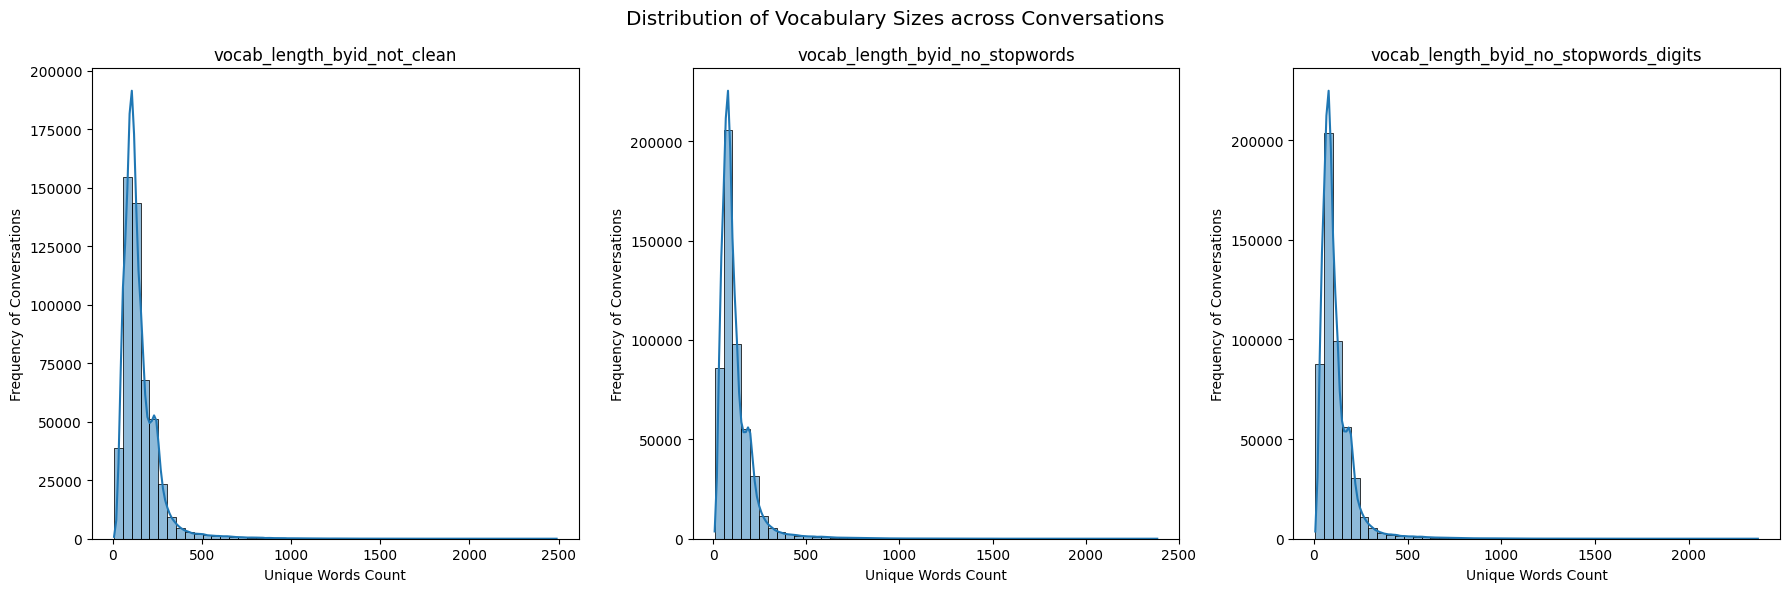

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i in range(3):
    temp = df[['vocab_length_byid_not_clean', 'vocab_length_byid_no_stopwords', 'vocab_length_byid_no_stopwords_digits']].iloc[:, i]
    sns.histplot(temp.values[::3], bins=50, kde=True, ax=axes[i])
    axes[i].set_title(temp.name)  # Set subplot title to temp.name
    axes[i].set_xlabel('Unique Words Count')
    axes[i].set_ylabel('Frequency of Conversations')

plt.suptitle('Distribution of Vocabulary Sizes across Conversations', fontsize = "x-large")
plt.tight_layout()
plt.show()

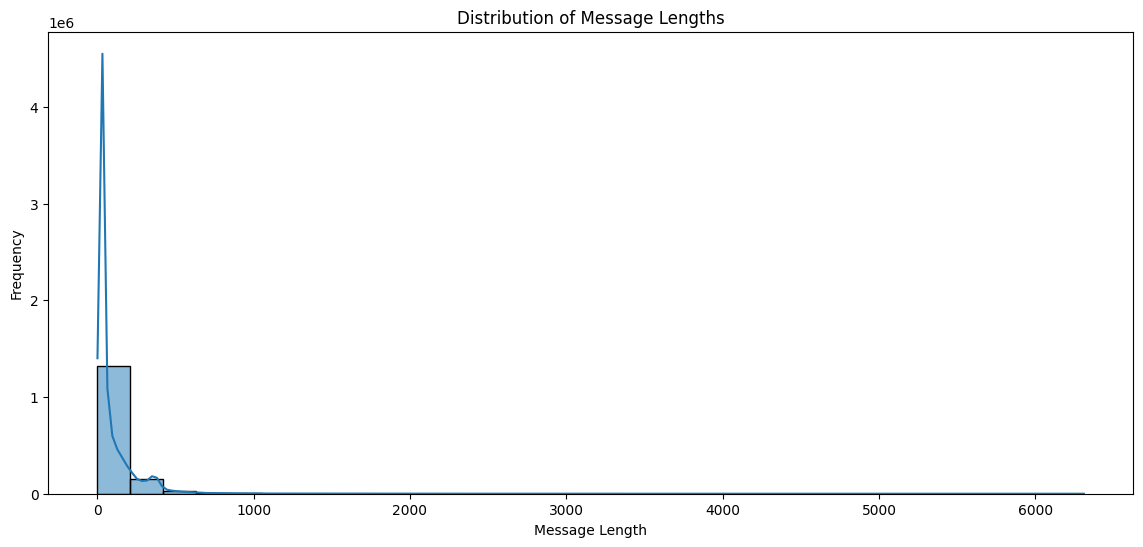

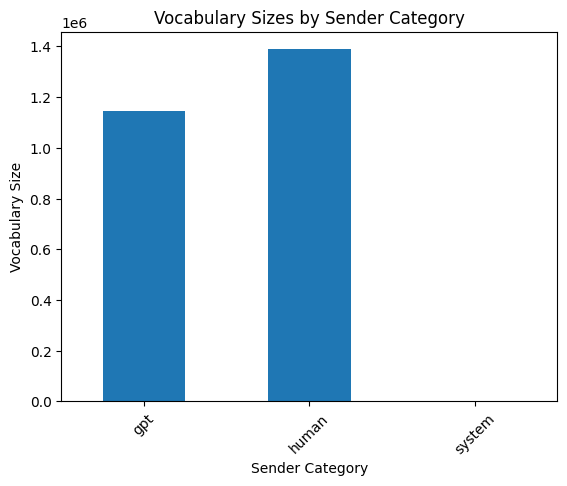

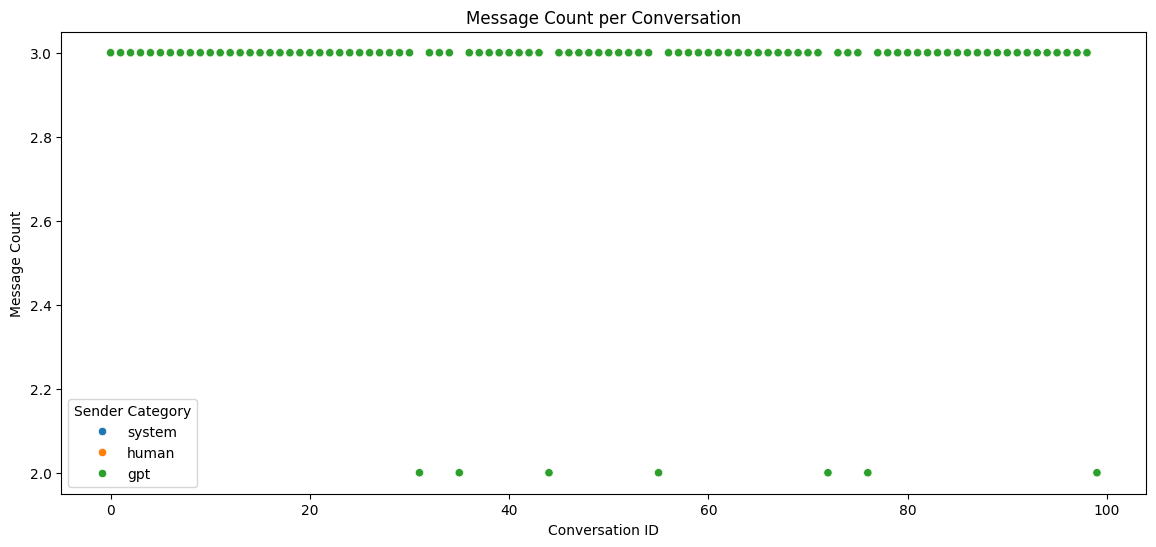

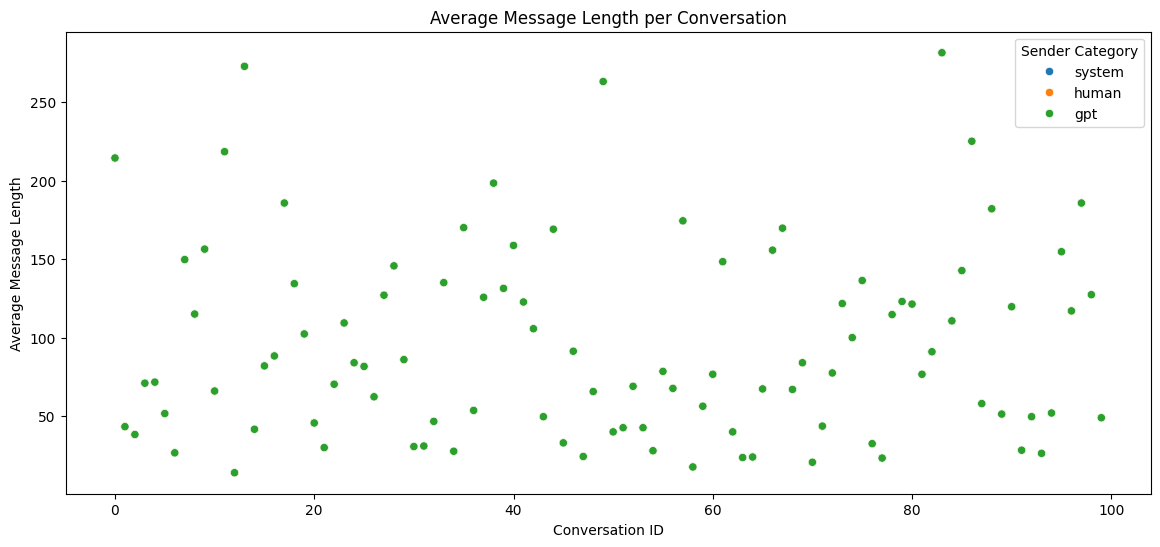

In [110]:

# Vocabulary Size Analysis
# Concatenate all messages and split into words to calculate overall vocabulary size
all_words = ' '.join(df['msg']).split()
vocab_size = len(set(all_words))

# Vocabulary size by `from` category
vocab_sizes_by_from = df.groupby('from')['msg'].apply(lambda x: len(set(' '.join(x).split())))

# Plotting Message Length Distribution
plt.figure(figsize=(14, 6))
sns.histplot(df['message_length'], bins=30, kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

# Plotting Vocabulary Sizes by `from` Category
vocab_sizes_by_from.plot(kind='bar')
plt.title('Vocabulary Sizes by Sender Category')
plt.xlabel('Sender Category')
plt.ylabel('Vocabulary Size')
plt.xticks(rotation=45)
plt.show()

# Plotting Message Count and Average Message Length per Conversation
# Selecting a subset of conversations for clearer visualization
subset_df = df[df['conv_id'] < 100]

plt.figure(figsize=(14, 6))
sns.scatterplot(data=subset_df, x='conv_id', y='message_count', hue='from')
plt.title('Message Count per Conversation')
plt.xlabel('Conversation ID')
plt.ylabel('Message Count')
plt.legend(title='Sender Category')
plt.show()

plt.figure(figsize=(14, 6))
sns.scatterplot(data=subset_df, x='conv_id', y='average_message_length', hue='from')
plt.title('Average Message Length per Conversation')
plt.xlabel('Conversation ID')
plt.ylabel('Average Message Length')
plt.legend(title='Sender Category')
plt.show()

## Sentence Embeddings

For you guys

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model = SentenceTransformer(path+ "all-MiniLM-L6-v2")

In [77]:
# For Marci
path = r"C:\Users\bartama\AppData\Roaming\sentence_transformers\\"
model = SentenceTransformer(path+ "all-MiniLM-L6-v2")

Embedding the Sentences: **MAYBE WE NEED TO DO IT ON THE INPUTS AGAIN**

In [81]:
batch_size = 100  # WE CAN ADJUST THIS
embeddings = []

for i in range(0, len(df.msg), batch_size):
    batch_messages = df.msg[i:i+batch_size].tolist()
    batch_embeddings = model.encode(batch_messages, show_progress_bar=False)
    embeddings.extend(batch_embeddings)

#### Alternatively:
#embeddings = model.encode(df.msg)

KeyboardInterrupt: 

In [ ]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=43)
sentence_embeddings_2d = tsne.fit_transform(embeddings)

In [ ]:
# Plotting with colors based on the source

color_map = {'system': 'red', 'human': 'blue', 'gpt': 'green'} # colorcode the source

plt.figure(figsize=(10, 10))
for i, (embedding, source) in enumerate(zip(sentence_embeddings_2d, df.from)):
    plt.scatter(embedding[0], embedding[1], color=color_map[source])
    plt.text(embedding[0]+0.01, embedding[1]+0.01, str(i), fontsize=9) ## IDK this is jus toptional

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Sentence Embeddings Visualized with t-SNE by Source')
plt.legend(color_map.keys())
plt.show()